In [1]:
# Department of Mechanical Science and Engineering  HUST 
# Tiyong Zhao
# Time: 2024/7/22 15:21

'''
https://blog.csdn.net/qq_45889931/article/details/129943445
'''

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
import matplotlib.pyplot as plt
import joblib
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import VotingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier

import warnings
warnings.filterwarnings("ignore")


# 读取数据
df=pd.read_excel(io=r"D:\gripper\数据收集和测试\一株3贴N\model&result\0830的模型对应的概率_WRF\All_data_0824.xlsx")
# print(df.values)
print(df.values[0,0])    #通过df.valued[]的方式引用数据
# print(type(df.values[0,1]))
row = len(df.values)
print(row)  # 输出行数，（数据的组数）


0.14836706033079328
1368


In [2]:
# 获取特征和标签，划分训练集、测试集
features_num = 16
features = df.values[:, 0:features_num]
labels = df.values[:, features_num]
train_data, test_data, train_label, test_label = train_test_split(features, labels, random_state=0, train_size=0.8)    # 训练集，测试集占比
                                                                    # sklearn.model_selection.

# 编码标签
le = LabelEncoder()
y_train_encoded = le.fit_transform(train_label)
train_label_encoded = le.fit_transform(train_label)
# 检查编码后的标签
print("Encoded labels:", train_label_encoded)    # 0,1,2,3,4   依次对应  'K', 'N', 'P', 'health', 'white'
print(train_label)

Encoded labels: [1 1 2 ... 4 0 1]
['N' 'N' 'P' ... 'white' 'K' 'N']


In [3]:
# 样本加权
class_weight = {0: 0.5, 1: 5.0, 2: 1.0, 3: 1.0, 4: 1.0}     # “balanced”
sample_weights = compute_sample_weight(class_weight, train_label_encoded)
# 打印样本权重
print("Sample weights:", sample_weights)

Sample weights: [5.  5.  1.  ... 1.  0.5 5. ]


In [4]:

'''构造加权随机森林'''
# 定义基分类器
tree = DecisionTreeClassifier(max_depth=5
                                    , criterion="entropy"    # entropy效果好
                                    , random_state=3           # 这个参数影响不大
                                    , splitter="best"
                                    , min_samples_leaf=1
                                    , max_features = 14
                                  # , min_impurity_decrease = 0.01     # 该参数默认，效果好
                                    , min_samples_split = 16)
rf = RandomForestClassifier(n_estimators=40            # 默认为10
                               , min_samples_split=5
                               , random_state=0
                               , oob_score=True          # 默认为False。推荐使用True，因为这样可以反映模型拟合后的泛化能力。
                               , criterion="entropy"     # 比gini系数好一些
                               , max_depth=3)
lr = LogisticRegression(    
    penalty='l2',              # 使用L2正则化
    C=20,                     # 正则化强度的倒数
    solver='lbfgs',        # 使用liblinear求解器
    multi_class='multinomial',
    max_iter=1000,              # 最大迭代次数
    class_weight='balanced')    # 平衡类权重)
svc = SVC(probability=True)
knn = KNeighborsClassifier(n_neighbors=5)
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=1000)
ada = AdaBoostClassifier(n_estimators=50)
gbc = GradientBoostingClassifier(n_estimators=50)
etc = ExtraTreesClassifier(n_estimators=10)
lda = LinearDiscriminantAnalysis()

# 定义加权投票分类器
model = VotingClassifier(estimators=[
    ('dt', tree),
    ('rf', rf),
    ('lr', lr),
    ('svc', svc),
    # ('knn', knn),    # knn,mlp,lda不支持samples_weight
   # ('mlp', mlp),
    ('ada', ada),
    ('gbc', gbc),
    ('etc', etc),
    # ('lda', lda)
    ],
    voting = 'soft', weights = [0.15, 0.15, 0.15, 0.15, 0.15, 0.15, 0.1]
)

In [5]:

# 训练
model = model.fit(train_data, train_label, sample_weight=sample_weights)
# 查看模型在训练集、测试集的分类效果
score_test = model.score(test_data, test_label)
print('测试集精度: ', score_test)
score_train = model.score(train_data, train_label)
print('训练集精度: ', score_train)

#save model
joblib.dump(model, r"D:\gripper\数据收集和测试\一株3贴N\model&result\0830的模型对应的概率_WRF\WRF_tree_model2.pkl")


测试集精度:  0.9781021897810219
训练集精度:  0.9972577696526508


['D:\\gripper\\数据收集和测试\\一株3贴N\\model&result\\0830的模型对应的概率_WRF\\WRF_tree_model2.pkl']

In [6]:

# 创建十折交叉验证对象
from sklearn.model_selection import train_test_split,cross_val_score, KFold
kfold = KFold(n_splits=10)
# 执行十折交叉验证
scores = cross_val_score(model, features, labels, cv=kfold)  # train_data, train_label   test_data, test_label
# 输出每折的准确率
for i, score in enumerate(scores):
    print("Fold {}: {:.4f}".format(i+1, score))
# 输出平均准确率
print("Average Accuracy: {:.4f}".format(scores.mean()))


Fold 1: 0.9854
Fold 2: 1.0000
Fold 3: 0.9708
Fold 4: 1.0000
Fold 5: 0.8248
Fold 6: 0.8394
Fold 7: 0.9635
Fold 8: 0.9781
Fold 9: 1.0000
Fold 10: 0.9485
Average Accuracy: 0.9511


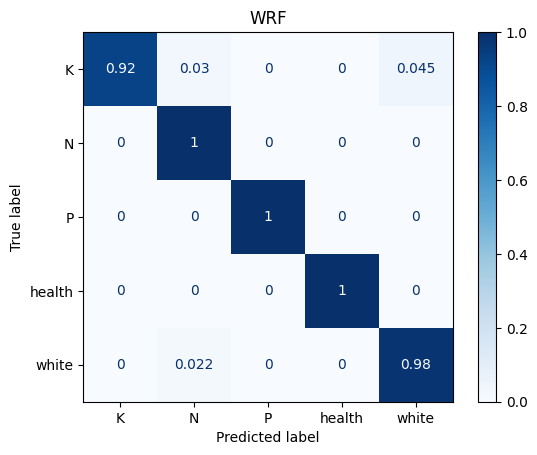

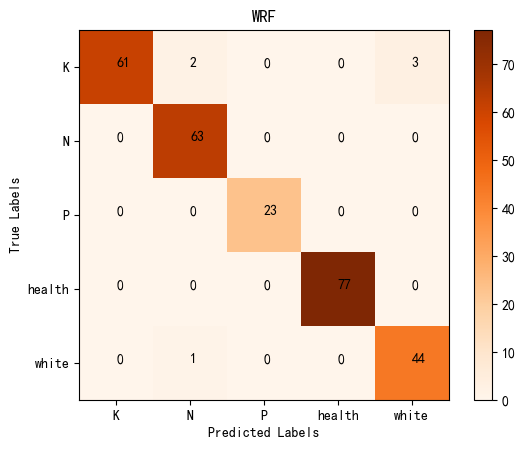

In [7]:

# '''
#  绘制：测试集的归一化的混淆矩阵(normalize confusion matrix)
# 如果不能绘制，就把随机森林可视化的代码注释一下
disp = ConfusionMatrixDisplay.from_estimator(
        model,
        test_data,
        test_label,
        cmap=plt.cm.Blues,
        normalize="true",
    )
disp.ax_.set_title('WRF')
plt.savefig(r"D:\gripper\数据收集和测试\一株3贴N\model&result\0830的模型对应的概率_WRF\WRF.png")    #保存图片一定要在plt.show()之前
#plt.savefig(r'C:\Users\jiang\Desktop\all_data\20240106SI\RF\RF confusion matrix normal.svg')
#plt.savefig(r'C:\Users\jiang\Desktop\all_data\20240106SI\RF\RF confusion matrix normal.eps')
plt.show()

#   绘制：测试集的混淆矩阵(confusion matrix)
pre_test_label = model.predict(test_data)
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(test_label, pre_test_label)
# 热度图，后面是指定的颜色块，可设置其他的不同颜色
plt.imshow(confusion, cmap=plt.cm.Oranges)
# ticks 坐标轴的坐标点
# label 坐标轴标签说明
indices = range(len(confusion))
plt.xticks(indices, ['K', 'N', 'P', 'health', 'white'])
plt.yticks(indices, ['K', 'N', 'P', 'health', 'white'])
plt.colorbar()
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.title('WRF')
# plt.rcParams两行是用于解决标签不能显示汉字的问题
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
# 显示数据
for first_index in range(len(confusion)):  # 第几行
    for second_index in range(len(confusion[first_index])):  # 第几列
        plt.text(first_index, second_index, confusion[second_index][first_index])
plt.savefig(r"D:\gripper\数据收集和测试\一株3贴N\model&result\0830的模型对应的概率_WRF\WRF2.png")    #保存图片一定要在plt.show()之前
plt.show()